In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix,roc_auc_score
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score,precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import cross_val_score,GridSearchCV

In [2]:
from sklearn.tree import export_graphviz
import os
import graphviz 

In [3]:
def eval(test,pred):
    acc = accuracy_score(test,pred)
    f1 = f1_score(test,pred)
    precision = precision_score(test,pred)
    recall = recall_score(test,pred)
    print('##############\n',confusion_matrix(test,pred),
    "############\n",f'acc_score: {acc}\n f1_score: {f1} \n precision: {precision} \n recall: {recall}')

## 임계값 =[] 리스트생성 후 for 구문
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        eval(y_test , custom_predict)


def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

## roc curve_plot    
def roc_curve_plot(y_test,pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba) ## 입력시 1레이블 컬럼만 추출
    
    # Roc curve를 plot 곡선으로 기름
    plt.plot(fprs,tprs,label='ROC')
    ## 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],"k--",label="ramdom")
    
    ## fpr x축을 scale을 0.1단위로 변경 x,y축 명 설정
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-sensitivity)')
    plt.ylabel('TPR(recall)')
    plt.legend()
    plt.show()

In [6]:
train = pd.read_csv('./datasets/model_data/train.csv',index_col=0)
test = pd.read_csv('./datasets/model_data/test.csv',index_col=0)

map = {'보통주식비율':'대주주지분율'}
train.rename(columns = map,inplace=True)
test.rename(columns = map,inplace=True)

list_int = ['대주주지분변화분', '외국인지분분변화', '자산', '비유동자산증가율', '유동자산증가율', '자기자본증가율',
       '정상영업이익증가율','매출액순이익률','자기자본순이익률',
       '매출액증가율', '광고선전비대매출액비율', '비유동비율', '당좌비율', '현금비율', '부채비율',
       '이자보상배율(이자비용)', '유보액대납입자본배율', '투자집중도', '1인년간평균급여(직원)', '토빈Q', 'WW지수',
       'RDS', '업력', '산업평균_총자산증가율차분', '대주주지분율', '외국인_주식분포비율','비유동비율']
x_train = train[list_int]
y_train = train[['target']]

x_test = test[list_int]
y_test = test[['target']]


col_int = ['유동자산증가율', '자기자본증가율', '산업평균_총자산증가율차분',
       '정상영업이익증가율', '매출액순이익률', '자기자본순이익률','투자집중도',
         '유보액대납입자본배율', '1인년간평균급여(직원)', '토빈Q',
         '업력', '대주주지분율', '외국인_주식분포비율']

x_train = x_train[col_int]
y_train = y_train[['target']]

x_test = x_test[col_int]
y_test = y_test[['target']]

In [301]:
y_train.value_counts()

target
0         5951
1         2417
dtype: int64

In [308]:
## 랜덤포레스트에서 최적의 하이퍼 파라미터를 찾아서 
## 적합후 feature_importance 변수 선택
rf = RandomForestClassifier(random_state=1,n_jobs=-1)
param = {
    "min_samples_split" : [2,3,4,5,6,7],
    "min_samples_leaf" : [1,2,3,4,5,],
    "max_depth" : [10,11,12,13],
    "max_features":["sqrt","log2"]
}



grid_rf = GridSearchCV(rf,param_grid=param,cv=5,refit=True,scoring='accuracy',n_jobs=-1)
grid_rf.fit(x_train,y_train)

scores_df = pd.DataFrame(grid_rf.cv_results_)
print(scores_df.iloc[:,4:])

    param_max_depth param_max_features param_min_samples_leaf  \
0                10               sqrt                      1   
1                10               sqrt                      1   
2                10               sqrt                      1   
3                10               sqrt                      1   
4                10               sqrt                      1   
..              ...                ...                    ...   
235              13               log2                      5   
236              13               log2                      5   
237              13               log2                      5   
238              13               log2                      5   
239              13               log2                      5   

    param_min_samples_split  \
0                         2   
1                         3   
2                         4   
3                         5   
4                         6   
..                      ...   
23

In [309]:
scores_df[scores_df['rank_test_score']==1][:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,2.983225,0.339955,1.607702,0.675919,10,sqrt,1,6,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.737754,0.749701,0.738351,0.759713,0.747161,0.746536,0.008101,1
34,3.123848,0.312700,0.977786,0.257986,10,log2,1,6,"{'max_depth': 10, 'max_features': 'log2', 'min...",0.737754,0.749701,0.738351,0.759713,0.747161,0.746536,0.008101,1


In [346]:

best_rf =RandomForestClassifier(random_state=1)
best_rf.fit(x_train,y_train)  


pred_rf = best_rf.predict(x_test)
pred_prob_rf = best_rf.predict_proba(x_test)[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=0.40).fit(pred_prob_rf) 
custom_rf = binarizer.transform(pred_prob_rf)


In [347]:
pd.DataFrame(data = best_rf.feature_importances_.reshape(-1,1),index=best_rf.feature_names_in_).sort_values(ascending=False,by=0)

,0
자기자본순이익률,0.109033
정상영업이익증가율,0.098784
자기자본증가율,0.091112
매출액순이익률,0.090828
외국인_주식분포비율,0.078342
유보액대납입자본배율,0.075146
산업평균_총자산증가율차분,0.069099
유동자산증가율,0.067694
1인년간평균급여(직원),0.064733
대주주지분율,0.064496


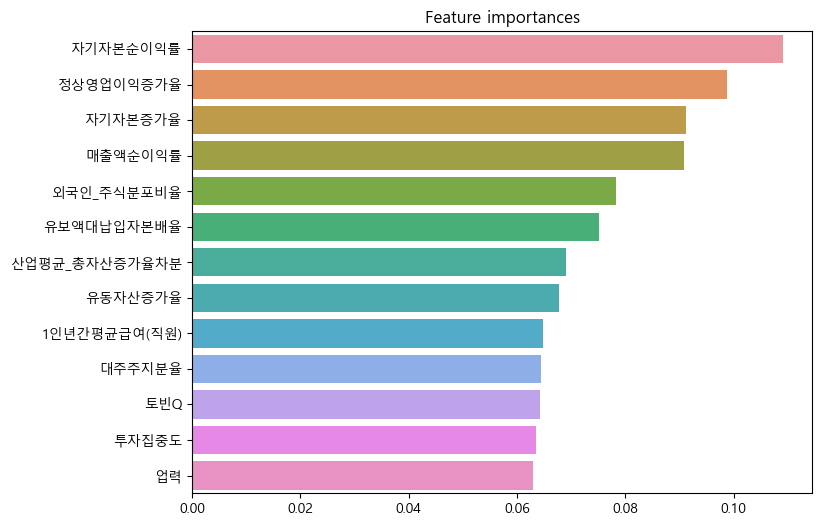

In [348]:
ftr_importances_values = best_rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=best_rf.feature_names_in_)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:]

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"
plt.figure(figsize=(8,6))
plt.title('Feature importances')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

In [349]:
get_eval_by_threshold(y_test,pred_prob_rf,thresholds=[0.4])


임곗값: 0.4
##############
 [[662 264]
 [197 416]] ############
 acc_score: 0.700454840805718
 f1_score: 0.6434648105181748 
 precision: 0.611764705882353 
 recall: 0.6786296900489397


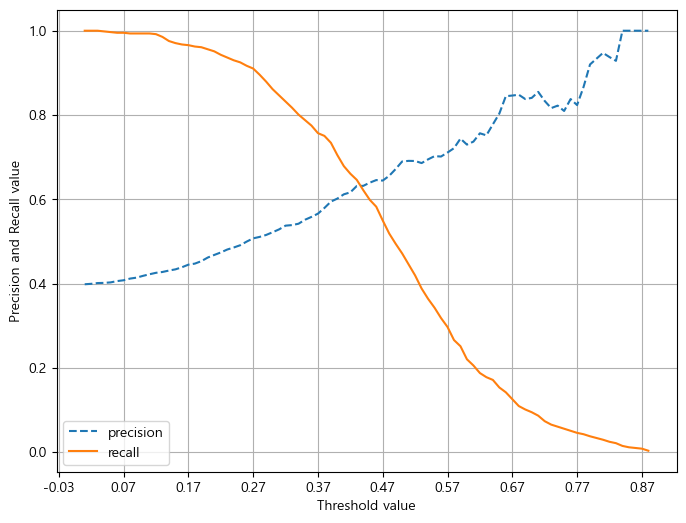

In [350]:
precision_recall_curve_plot(y_test,pred_prob_rf)

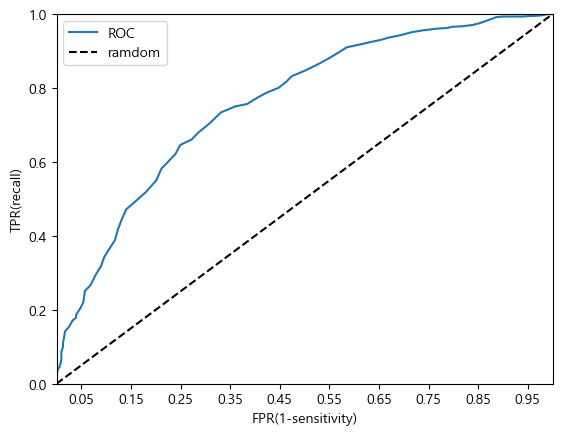

auc 값: 0.76


In [351]:
## roc 커브 auc 값
roc_curve_plot(y_test,pred_prob_rf)
auc_score = roc_auc_score(y_test,pred_prob_rf)
print(f'auc 값: {np.round(auc_score,4)}')

Text(51.722222222222214, 0.5, 'Actual')

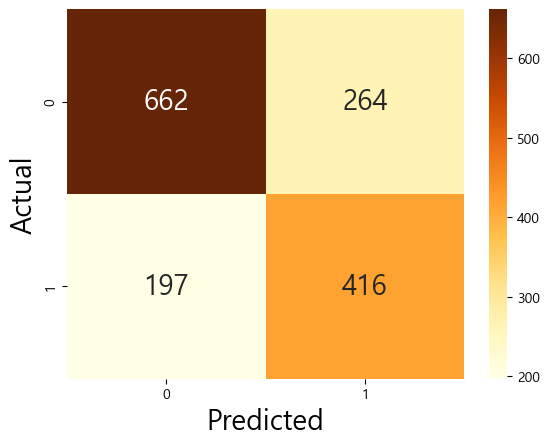

In [355]:
cm = confusion_matrix(y_test, custom_rf)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='YlOrBr', fmt='g')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

In [ ]:
export_graphviz(best_rf.estimators_[0], out_file = "rf{}.dot".format(0),feature_names=best_rf.feature_names_in_,
                rounded=True, proportion=False,
                filled=True, precision=2)
with open("rf{}.dot".format(0)) as f1:
    dot_graph1 = f1.read()
graphviz.Source(dot_graph1)

In [335]:
df = pd.read_csv('./datasets/이상치제거csv/이상치제거전.csv',index_col=0)
df['회계년도'] = df['회계년도'].astype('int')
df['거래소코드'] = df['거래소코드'].astype('int')

In [336]:
test['predict'] = custom_rf
test['predict'] = test['predict'].astype('int')
test[['회계년도','회사명','predict']].to_csv('예측.csv',encoding='utf-8-sig')

In [337]:
df.columns

Index(['회사명', '거래소코드', '회계년도', '대주주지분변화분', '외국인지분분변화', '상장일', '자산',
       '당기순이익(손실)', '비유동자산증가율', '유동자산증가율', '자기자본증가율', '매출액증가율', '정상영업이익증가율',
       '순이익증가율', '총포괄이익증가율', '매출액순이익률', '총자본순이익률', '자기자본순이익률', '매출원가대매출액비율',
       '광고선전비대매출액비율', '유보율', '비유동비율', '유동비율', '당좌비율', '현금비율', '부채비율', '유동부채비율',
       '차입금비율', '이자보상배율(이자비용)', '유보액대비율', '유보액대납입자본배율', '투자집중도',
       '통계청 한국표준산업분류 10차(대분류)', '1인년간평균급여(직원)', '토빈Q', 'target', 'WW지수', 'RDS',
       '수명주기', '산업평균_총자산증가율차분', '보통주식비율', '외국인_주식분포비율', '업력'],
      dtype='object')

In [ ]:
test[(test['predict']==1) & (test['target']==1)]

In [339]:
예측 = test[['회사명','회계년도','predict']]

In [340]:
완성 = df.merge(예측,on=['회사명','회계년도'],how='left')

In [341]:
완성.to_csv('./datasets/model_data/예측+이상치제거전.csv',encoding='utf-8-sig')